# New Samples

As opposed to the previous treatment plans I've sampled, this time I only had 7 objective function terms (two for the PTV and one for each of the five OARs we're focusing on). For the PTV, I used a min/max dose objectives, and for the OARs I used max DVH objectives that corresponded to their clinical goals. My motivation for these changes was that before, the objective terms didn't directly correspond to the clinical goals, so I wasn't really measuring the right results. I also tuned the PTV max dose parameter, wherease before I only tuned OAR parameters. I chose not to tune the PTV min dose parameter, since that's what I use to normalize the plan (I'm actually normalizing to the D95, not the min dose, but I figure it's close enough). 

This plan can be found in the RayStation plan "goalObjs".

## Clinical Goals
idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320

### Modifications

For the DVH objectives specified in cm$^3$, I calculated percents based on total volume:

Name | Goal Volume | Total Volume | Percent Volume
-|-|-|-
Rib | 1 | 367.26 | 0.27
SpinalCanal | 0.35 | 51.93 | 0.67
Chestwall_L | 30 | 1468.53 | 2.04
Heart | 15 | 816.05 | 1.84


## Objective Terms

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min Dose 4800 cGy | MinDose | 4800 | 0 | 1
1 | PTV | Max Dose 6200 cGy | MaxDose | 6200 | 0 | 1
2 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1
3 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
4 | Heart | Max DVH 2800 to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import utils

In [109]:
roi_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs', 'PTV']
samples = np.load('samples_6_10.npy', allow_pickle=True)
par_dict = {roi: utils.roi_pars(samples, roi)[0] for roi in roi_list}
goal_dict = {roi: [samples[ii][4][roi][-1]['ResultValue'] for ii in range(len(samples))] for roi in roi_list}

# Dose Level Parameter Ranges

For the OARs, I sampled between the 50-100% of the max dose range. For the PTV, I sampled from the average of the min/max doses to the max dose.

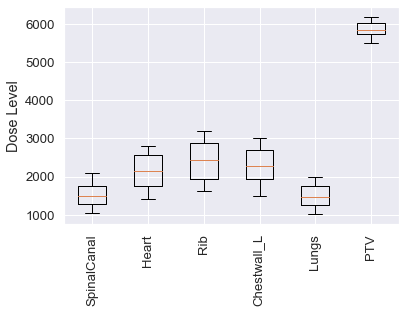

In [22]:
par_data = [par_dict[roi] for roi in roi_list]
plt.boxplot(par_data)
plt.xticks(ticks=1+np.arange(len(roi_list)), labels=roi_list, rotation=90)
plt.ylabel('Dose Level');

# Goal Value Ranges

Here are the values that the resulting max doses achieved.

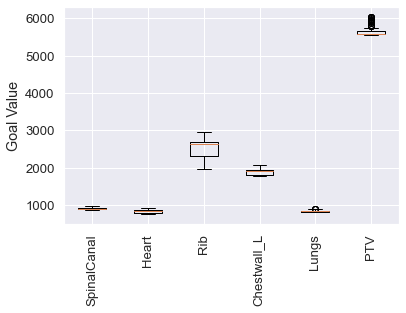

In [110]:
goal_data = [goal_dict[roi] for roi in roi_list]
plt.boxplot(goal_data)
plt.xticks(ticks=1+np.arange(len(roi_list)), labels=roi_list, rotation=90)
plt.ylabel('Goal Value');

# Correlation Between Parameters and Goals

There are definitely two groups competing against each other:
* SpinalCanal, PTV, Lungs
* Rib, Heart, Chestwall_L

The only parameter that seemed to influence the results was the rib parameter.

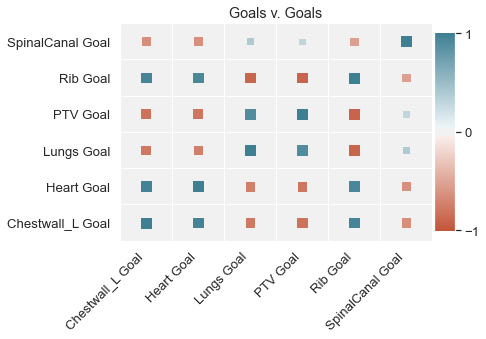

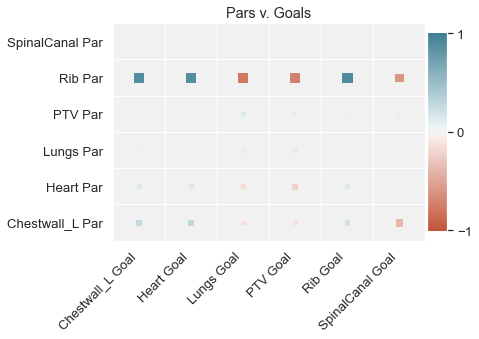

In [111]:
res_dict = {}
par_labels = [f'{roi} Par' for roi in roi_list]
goal_labels = [f'{roi} Goal' for roi in roi_list]
for roi in roi_list:
    res_dict[f'{roi} Par'] = par_dict[roi]
    res_dict[f'{roi} Goal'] = goal_dict[roi]
utils.corrplot(res_dict, 'Goals v. Goals', x_labels=goal_labels, y_labels=goal_labels)
plt.figure()
utils.corrplot(res_dict, 'Pars v. Goals', x_labels=par_labels, y_labels=goal_labels)

# Plotting Goals v. Pars

Again, it's pretty clear that the ribs are what's driving the results.

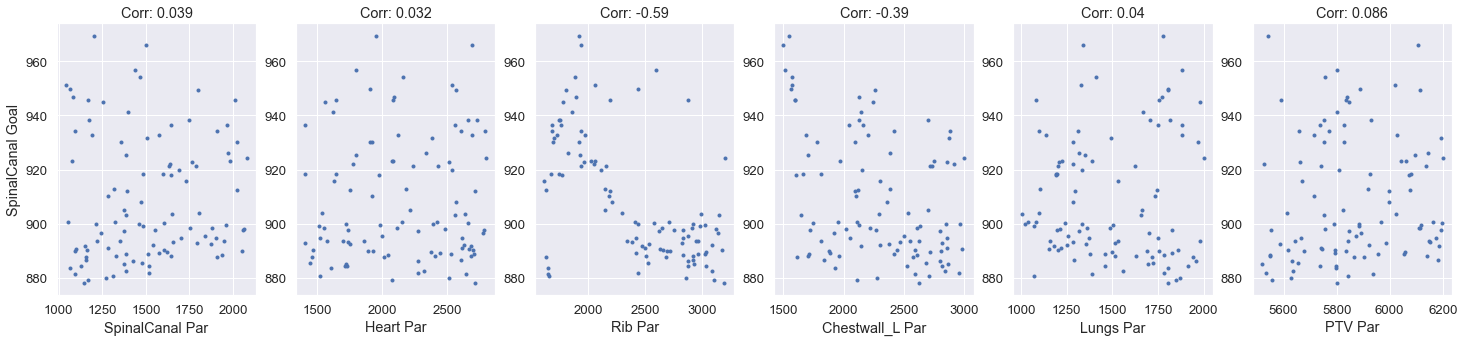

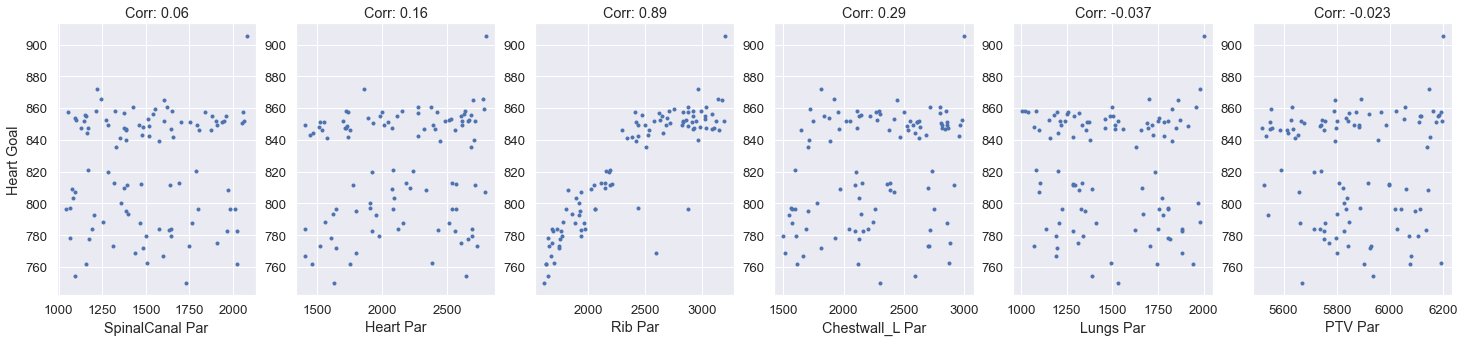

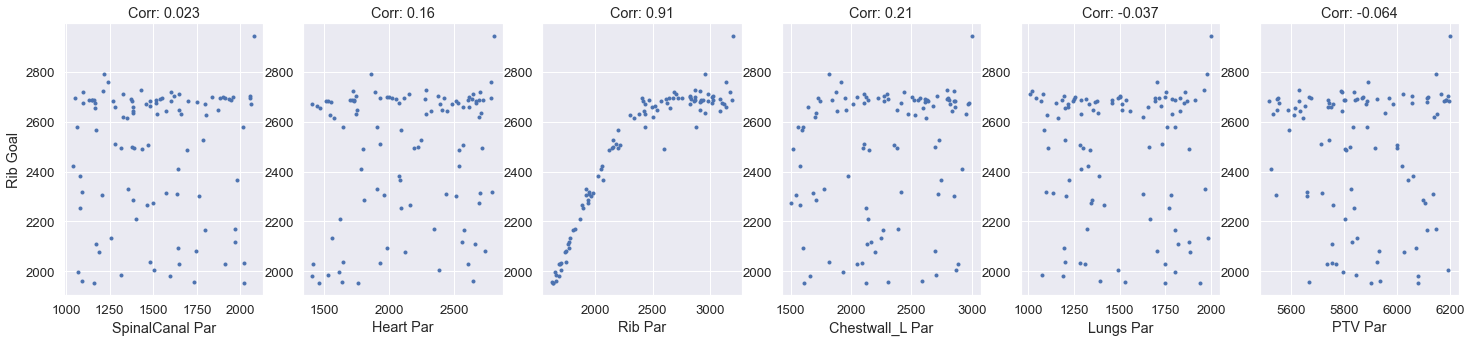

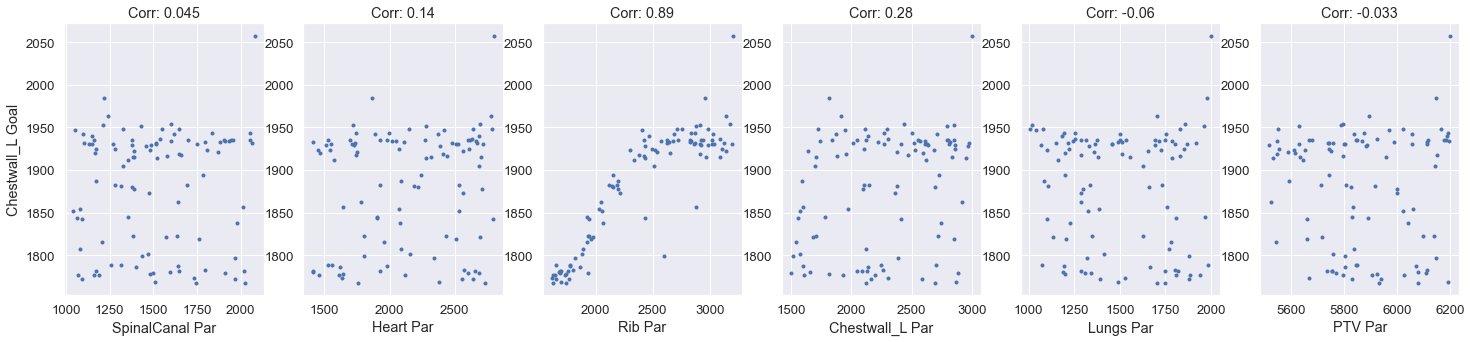

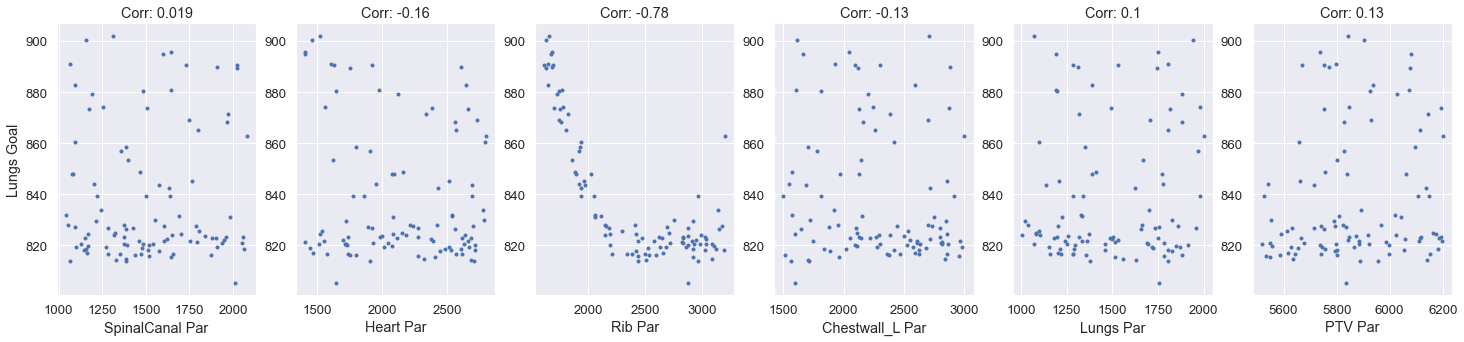

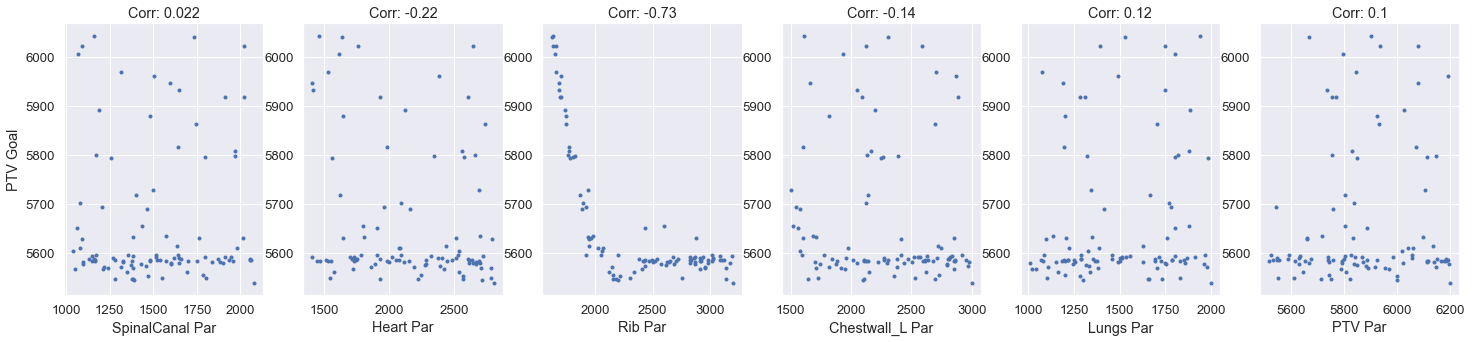

In [112]:
for ii in range(len(roi_list)):
    fig, ax = plt.subplots(1, 6, figsize=(25, 5))
    for jj in range(len(roi_list)):
        x = par_dict[roi_list[jj]]
        y = goal_dict[roi_list[ii]]
        ax[jj].plot(x, y, '.')
        ax[jj].set_xlabel(f'{roi_list[jj]} Par')
        ax[jj].set_title(f'Corr: {np.corrcoef(x, y)[0, 1]:.2}')
    ax[0].set_ylabel(f'{roi_list[ii]} Goal')

# Predicting Goals Using Rib Parameter

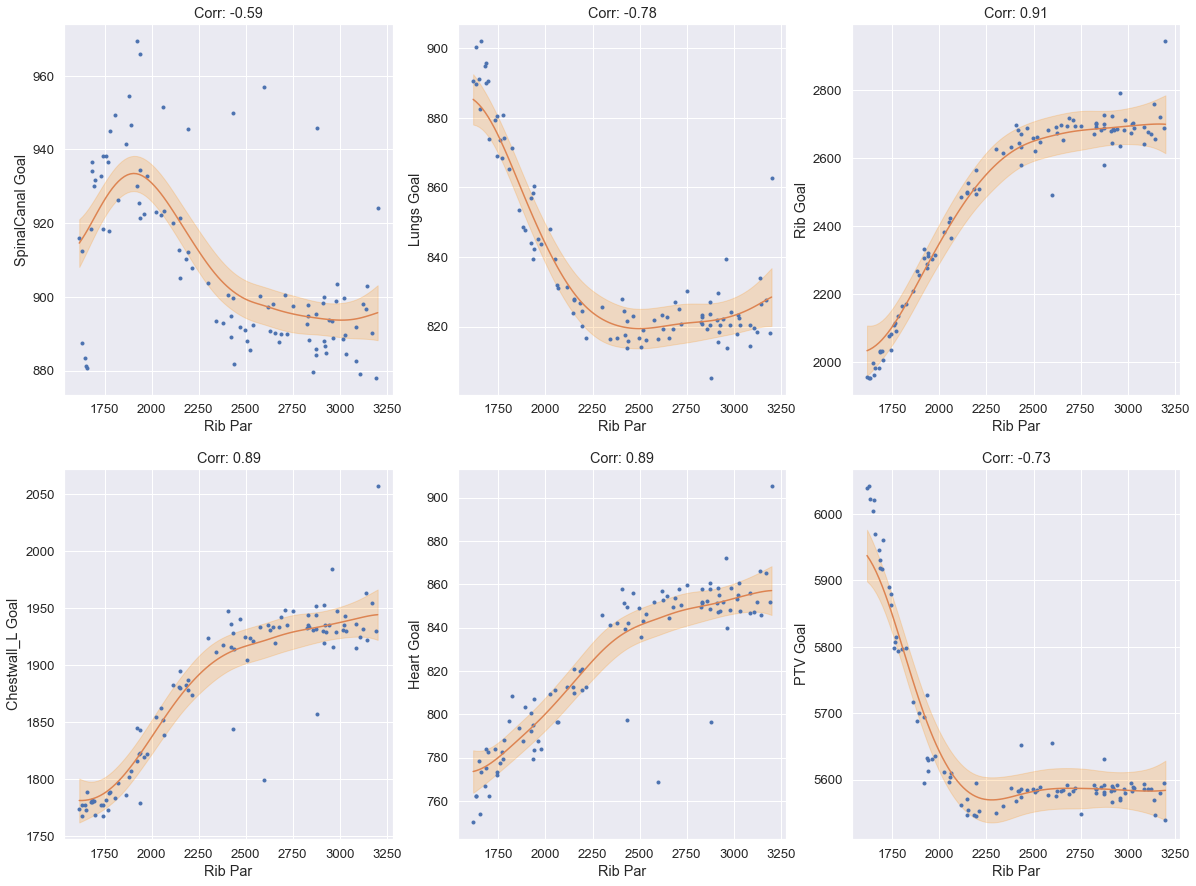

In [617]:
# Build model
x_data = np.array(par_dict['Rib'])
y_data = np.array([goal_dict[roi] for roi in roi_list]).T
gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e0)\
          .fit(x_data.reshape(-1, 1), (y_data - np.mean(y_data, axis=0))/np.std(y_data, axis=0))

# Make predictions
x_est = np.linspace(min(x_data), max(x_data), 100)
y_est, std = gpr.predict(x_est.reshape(-1, 1), return_std=True)
y_est = y_est*np.std(y_data, axis=0) + np.mean(y_data, axis=0)
std = np.outer(std, np.std(y_data, axis=0))

# Plot results
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for ii in range(len(roi_list)):
    ax[np.mod(ii, 2), np.mod(ii, 3)].plot(x_data, y_data[:, ii], '.')
    ax[np.mod(ii, 2), np.mod(ii, 3)].plot(x_est, y_est[:, ii])
    ax[np.mod(ii, 2), np.mod(ii, 3)].fill_between(x_est, y_est[:, ii] - std[:, ii],
                                                  y_est[:, ii] + std[:, ii], color='darkorange', alpha=0.2)
    ax[np.mod(ii, 2), np.mod(ii, 3)].set_xlabel('Rib Par')
    ax[np.mod(ii, 2), np.mod(ii, 3)].set_ylabel(f'{roi_list[ii]} Goal')
    ax[np.mod(ii, 2), np.mod(ii, 3)].set_title(f'Corr: {np.corrcoef(x_data, y_data[:, ii])[0, 1]:.2}')

# Different Scoring Functions

Text(0, 0.5, 'Total Score')

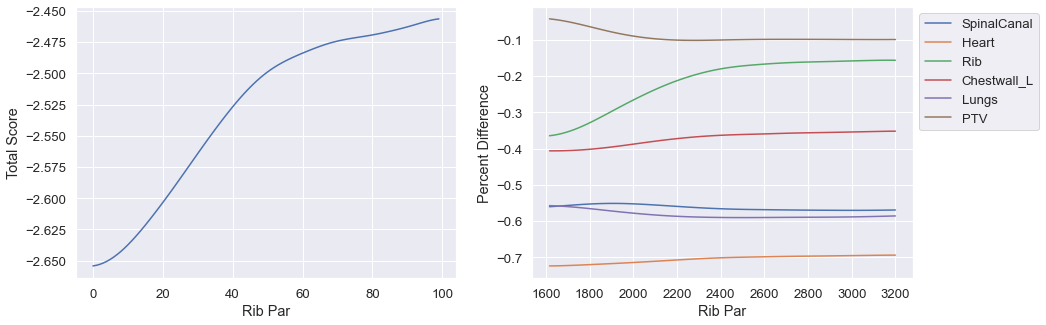

In [691]:
# Score based on percent decrease from maximum goal value

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
score = np.zeros(y_est.shape[0])
for ii in range(len(roi_list)):
    ax[1].plot(x_est, (y_est[:, ii] - max_vals[ii])/max_vals[ii])
    score += (y_est[:, ii] - max_vals[ii])/max_vals[ii]
ax[1].set_xlabel('Rib Par')
ax[1].set_ylabel('Percent Difference')
ax[1].legend(labels=roi_list, bbox_to_anchor=(1, 1))
ax[0].plot(score)
ax[0].set_xlabel('Rib Par')
ax[0].set_ylabel('Total Score')

# Here the rib had the largest change, so it dominates the shape of the score

Text(0, 0.5, 'Total Score')

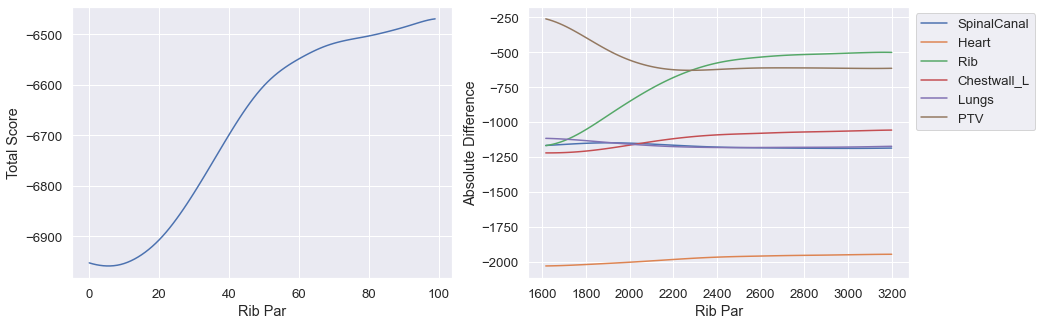

In [695]:
# Score based on absolute decrease from maximum goal value

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
score = np.zeros(y_est.shape[0])
for ii in range(len(roi_list)):
    ax[1].plot(x_est, (y_est[:, ii] - max_vals[ii]))
    score += (y_est[:, ii] - max_vals[ii])
ax[1].set_xlabel('Rib Par')
ax[1].set_ylabel('Absolute Difference')
ax[1].legend(labels=roi_list, bbox_to_anchor=(1, 1))
ax[0].plot(score)
ax[0].set_xlabel('Rib Par')
ax[0].set_ylabel('Total Score')

# Rib still dominates, but minimum changes

Text(0, 0.5, 'Total Score')

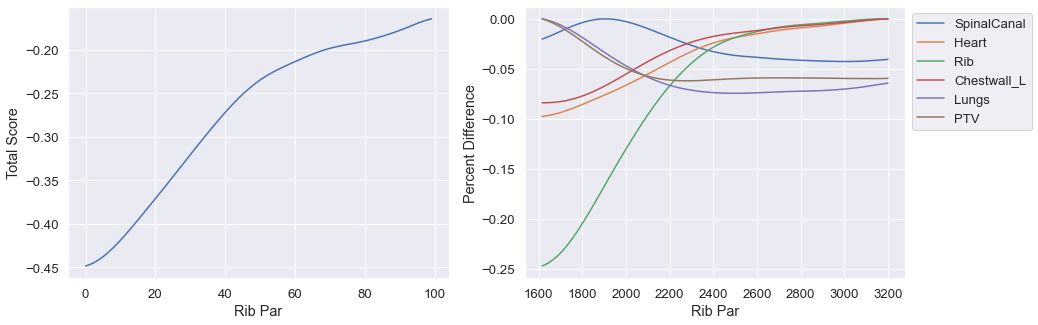

In [693]:
# Score based on percent decrease from max value achieved over all samples

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
score = np.zeros(y_est.shape[0])
for ii in range(len(roi_list)):
    ax[1].plot(x_est, (y_est[:, ii] - max(y_est[:, ii]))/max(y_est[:, ii]))
    score += (y_est[:, ii] - max(y_est[:, ii]))/max(y_est[:, ii])
ax[1].set_xlabel('Rib Par')
ax[1].set_ylabel('Percent Difference')
ax[1].legend(labels=roi_list, bbox_to_anchor=(1, 1))
ax[0].plot(score)
ax[0].set_xlabel('Rib Par')
ax[0].set_ylabel('Total Score')

# The rib still dominates
# The problem with this approach is that we don't necessarily know the max value a priori
# Same shape that we had before when we used percent difference

Text(0, 0.5, 'Total Score')

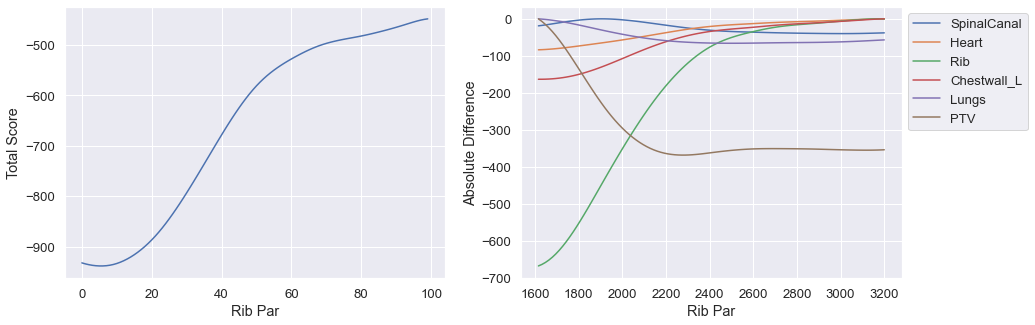

In [696]:
# Score based on absolute decrease from max value achieved over all samples

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
score = np.zeros(y_est.shape[0])
for ii in range(len(roi_list)):
    ax[1].plot(x_est, (y_est[:, ii] - max(y_est[:, ii])))
    score += (y_est[:, ii] - max(y_est[:, ii]))
ax[1].set_xlabel('Rib Par')
ax[1].set_ylabel('Absolute Difference')
ax[1].legend(labels=roi_list, bbox_to_anchor=(1, 1))
ax[0].plot(score)
ax[0].set_xlabel('Rib Par')
ax[0].set_ylabel('Total Score')

# The rib still dominates
# Same shape we had before when we used absolute difference

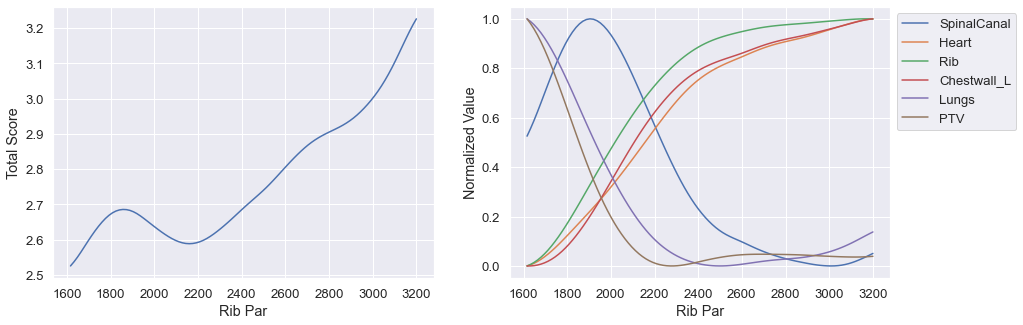

In [698]:
# Score based on normalized changes in values

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
score = np.zeros(y_est.shape[0])
score2 = np.zeros(y_est.shape[0])
for ii in range(len(roi_list)):
    ax[1].plot(x_est, (y_est[:, ii] - min(y_est[:, ii]))/(max(y_est[:, ii]) - min(y_est[:, ii])))
    score += (y_est[:, ii] - min(y_est[:, ii]))/(max(y_est[:, ii]) - min(y_est[:, ii]))
ax[1].set_xlabel('Rib Par')
ax[1].set_ylabel('Normalized Value')
ax[1].legend(labels=roi_list, bbox_to_anchor=(1, 1))
ax[0].plot(x_est, score)
ax[0].set_xlabel('Rib Par')
ax[0].set_ylabel('Total Score');

# Here we get something more interesting, but same ultimate result!
# The local minimum is interesting, based on the kink in SpinalCanal 
# (which might be an artifact of the GP and not really be in the data...)

# Still have the problem that we don't know the min and max values a priori

# We could have a custom score that the treatment planner makes, that shows regions
# where improvement is valued and where it's not as important
# I think that's probably the most useful way to go

# Predict Score From Goals From Rib

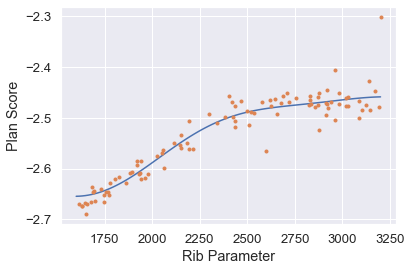

In [625]:
# Build goal model
x_data = np.array(par_dict['Rib'])
y_data = np.array([goal_dict[roi] for roi in roi_list]).T
gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0)\
          .fit(x_data.reshape(-1, 1), (y_data - np.mean(y_data, axis=0))/np.std(y_data, axis=0))

# Build score model
max_vals = np.array([samples[0][4][roi][-1]['DoseValue'] for roi in roi_list])
def score_est(rib_par):
    y_est = gpr.predict(np.array(rib_par).reshape(-1, 1))[0]
    y_est = y_est*np.std(y_data, axis=0) + np.mean(y_data, axis=0)
    return sum((y_est - max_vals)/max_vals)

# Plot results
rib_pars = np.linspace(1600, 3200, 100)
score_vals = [score_est(par) for par in rib_pars]
score_true = [sum((y_data[ii] - max_vals)/max_vals) for ii in range(100)]
plt.plot(rib_pars, score_vals)
plt.plot(par_dict['Rib'], score_true, '.')
plt.xlabel('Rib Parameter')
plt.ylabel('Plan Score');

# What this tells me is that we can keep going lower with the rib parameter
# The only question is if we go lower, will the other parameters come into play?

Error: 0.2569325327680417


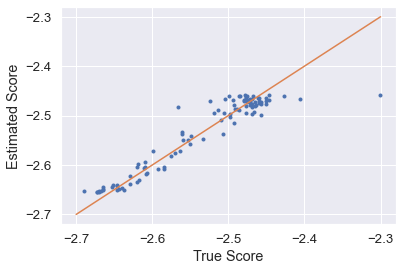

In [570]:
# Error
score_vals1 = np.array([score_est(x) for x in x_data])
print(f'Error: {np.linalg.norm(score_true - score_vals1)}')
plt.plot(score_true, score_vals1, '.')
plt.plot([-2.7, -2.3], [-2.7, -2.3])
plt.xlabel('True Score')
plt.ylabel('Estimated Score');

# Predict Score From Rib

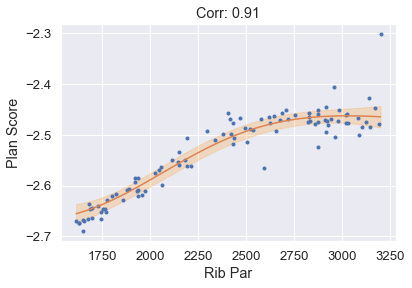

In [571]:
# Build model
x_data = np.array(par_dict['Rib'])
temp = np.array([goal_dict[roi] for roi in roi_list]).T
y_data = np.array([sum((temp[ii] - max_vals)/max_vals) for ii in range(100)])
gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0)\
          .fit(x_data.reshape(-1, 1), (y_data - np.mean(y_data))/np.std(y_data))

# Make predictions
x_est = np.linspace(min(x_data), max(x_data), 100)
y_est, std = gpr.predict(x_est.reshape(-1, 1), return_std=True)
y_est = y_est*np.std(y_data) + np.mean(y_data)
std *= np.std(y_data)

# Plot results
plt.plot(x_data, y_data, '.')
plt.plot(x_est, y_est)
plt.fill_between(x_est, y_est - std, y_est + std, color='darkorange', alpha=0.2)
plt.xlabel('Rib Par')
plt.ylabel('Plan Score')
plt.title(f'Corr: {np.corrcoef(x_data, y_data)[0, 1]:.2}');

Error: 0.2656470908983318


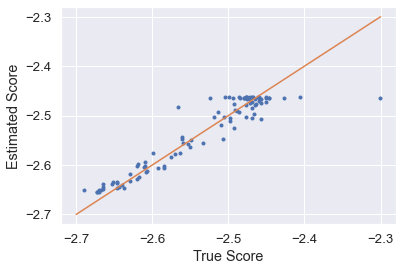

In [572]:
# Error
y_est2 = gpr.predict(x_data.reshape(-1, 1))
y_est2 = y_est2*np.std(y_data) + np.mean(y_data)
print(f'Error: {np.linalg.norm(y_est2 - y_data)}')
plt.plot(y_data, y_est2, '.')
plt.plot([-2.7, -2.3], [-2.7, -2.3])
plt.xlabel('True Score')
plt.ylabel('Estimated Score');

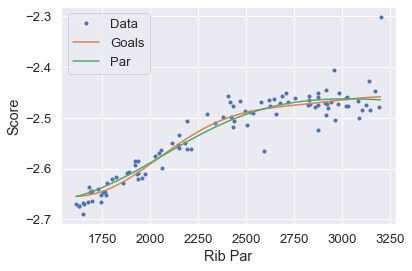

In [574]:
# Both curves together
plt.plot(x_data, y_data, '.')
plt.plot(x_est, score_vals)
plt.plot(x_est, y_est)
plt.xlabel('Rib Par')
plt.ylabel('Score')
plt.legend(['Data', 'Goals', 'Par']);

# Predict Score From All Pars

Adding more features to the  model makes it worse when the features are irrelevant.

Training Error: 0.2695870159974938
Test Error: 0.5693516956797748


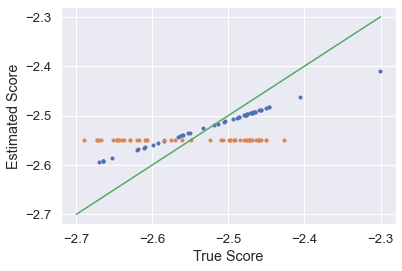

In [615]:
# Build model
x_data = np.array([par_dict[roi] for roi in roi_list]).T
temp = np.array([goal_dict[roi] for roi in roi_list]).T
y_data = np.array([sum((temp[ii] - max_vals)/max_vals) for ii in range(len(temp))])

n = 50

x_train = x_data[:n, :]
y_train = y_data[:n]

x_test = x_data[n:, :]
y_test = y_data[n:]

gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0)\
          .fit(x_train, (y_train - np.mean(y_train))/np.std(y_train))

# Error
y_est1 = gpr.predict(x_train)
y_est1 = y_est1*np.std(y_train) + np.mean(y_train)
y_est2 = gpr.predict(x_test)
y_est2 = y_est2*np.std(y_test) + np.mean(y_test)
print(f'Training Error: {np.linalg.norm(y_est1 - y_train)}')
print(f'Test Error: {np.linalg.norm(y_est2 - y_test)}')
plt.plot(y_train, y_est1, '.')
plt.plot(y_test, y_est2, '.')
plt.plot([-2.7, -2.3], [-2.7, -2.3])
plt.xlabel('True Score')
plt.ylabel('Estimated Score');

# Overfitting problem, including irrelevant features problem

# Some exploration...

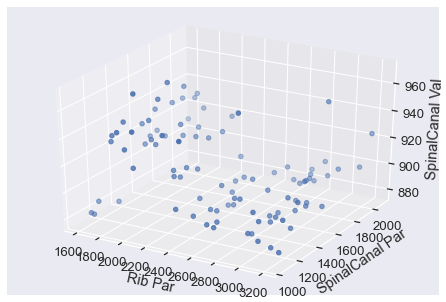

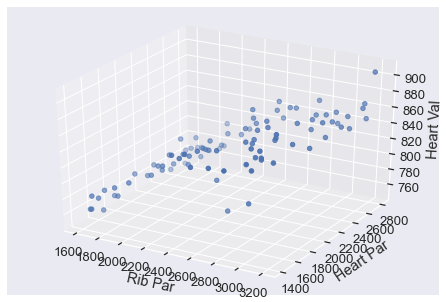

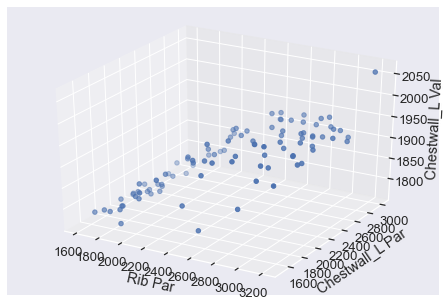

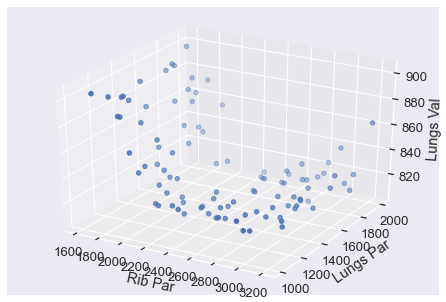

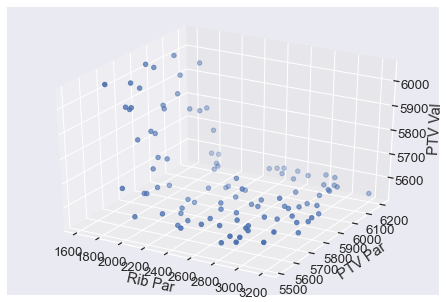

In [222]:
from mpl_toolkits.mplot3d import Axes3D

for roi in roi_list:
    if roi != 'Rib':
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(par_dict['Rib'], par_dict[roi], goal_dict[roi])
        ax.set_xlabel('Rib Par')
        ax.set_ylabel(f'{roi} Par')
        ax.set_zlabel(f'{roi} Val');

# PCA exploration

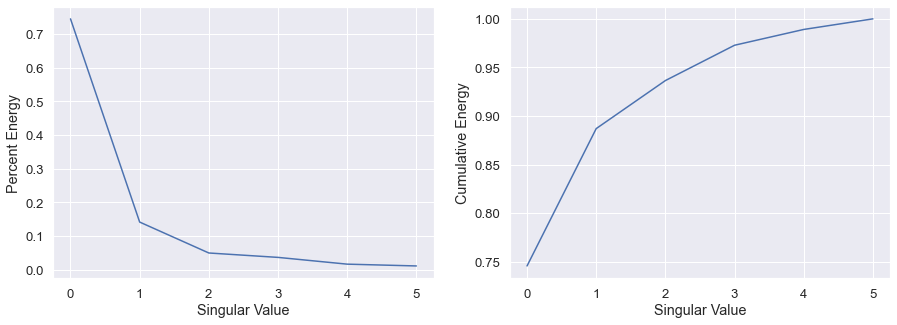

In [706]:
# How many dimensions do we have in the goals?
goal_mat = np.array([goal_dict[roi] for roi in roi_list])
goal_mat -= np.outer(np.mean(goal_mat, axis=1), np.ones(goal_mat.shape[1]))
[U, S, Vh] = np.linalg.svd(goal_mat)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(S/sum(S))
ax[0].set_xlabel('Singular Value')
ax[0].set_ylabel('Percent Energy');

ax[1].plot(np.cumsum(S)/sum(S))
ax[1].set_xlabel('Singular Value')
ax[1].set_ylabel('Cumulative Energy');

# Didn't divide by standard deviation, since all are in the same unit cGy

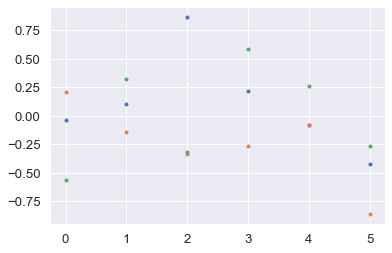

In [702]:
# First two singular vectors
plt.plot(u[:, 0], '.')
plt.plot(u[:, 1], '.')
plt.plot(u[:, 2], '.');

# Notice that the first one identifies the Rib (2) and PTV (5) as the most important
# directions, and they are opposite signs

# I'm not sure how to interpret the second one
# Same teams, except PTV switches. Which parameter, or combination or parameters, is driving this?

# Don't know how to interpret the third singular vector...

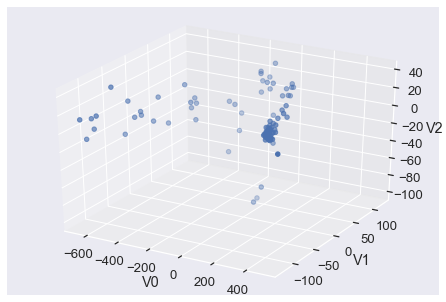

In [707]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(s[0]*vh[0], s[1]*vh[1], s[2]*vh[2], '.')
ax.set_xlabel('V0')
ax.set_ylabel('V1')
ax.set_zlabel('V2');

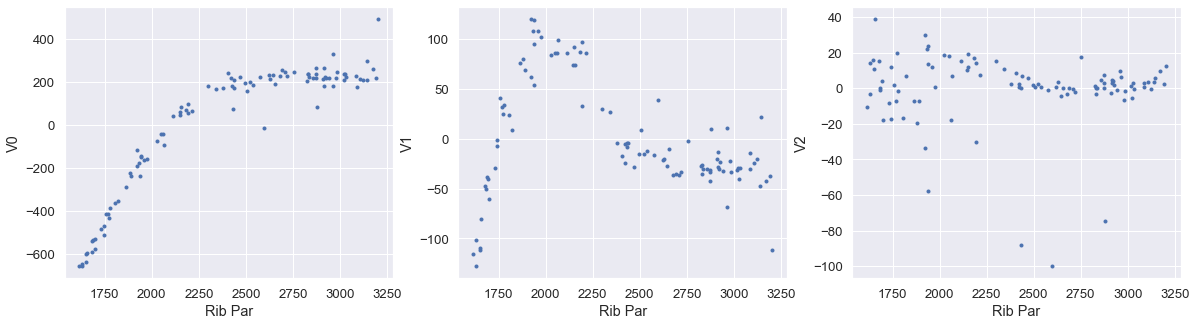

In [710]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for ii in range(3):
    ax[ii].plot(par_dict['Rib'], s[ii]*vh[ii], '.')
    ax[ii].set_xlabel('Rib Par')
    ax[ii].set_ylabel(f'V{ii}')

# First direction looks like rib or score (which rib dominates)
# Not sure about second direction
# Third direction could just be noise

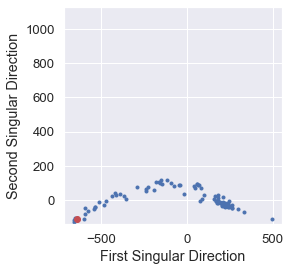

In [716]:
plt.plot(s[0]*vh[0], s[1]*vh[1], '.')
plt.plot(s[0]*vh[0, idx], s[1]*vh[1, idx], 'ro') # best score
plt.xlabel('First Singular Direction')
plt.ylabel('Second Singular Direction')
plt.axis('square');

In [717]:
# If we used SVD, it guess it would be more to compute or estimate values more efficiently,
# but I'm not sure it makes interpretability or scoring more intuitive at all

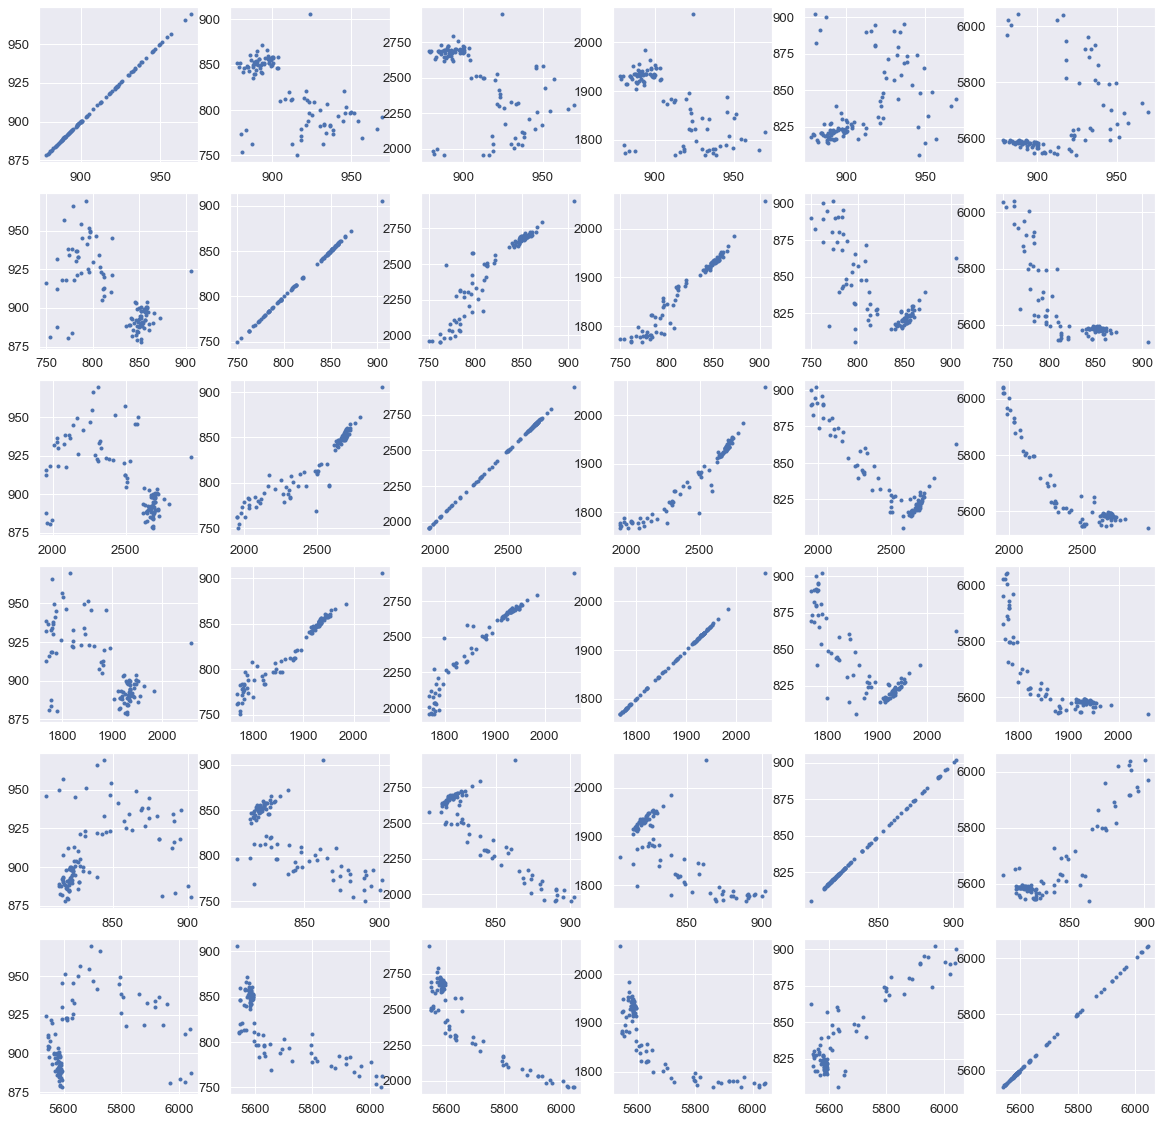

In [387]:
# Relationships between goal values
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
for ii in range(len(roi_list)):
    for jj in range(len(roi_list)):
        ax[ii, jj].plot(goal_dict[roi_list[ii]], goal_dict[roi_list[jj]], '.')